# Описание задачи
## В задачи пректа входит:
- Нахождение данных для обученяи модели: парсинг и/или иные источники;
- Предобработка полученных данных
- Создание новых признаков с использованием полученных данных;
- Отбор признаков;
- Подбор модели/ансамбля моделей;
- Обучение и тестирование отобранной модели на отобранных признаках;
- Подбор макропараметров модели на отобранных признаках;
- Получение предсказанных моделью значений, подготовка и отправка submission

# Импорт библиотек, установка параметров, определение функций
## Импорт бибилиотек

In [1]:
import pandas as pd
import numpy as np
import json 
import os
import requests
import seaborn as sns

from pprint import pprint
from bs4 import BeautifulSoup 

## Установка параметров

In [2]:
%pylab inline

pd.set_option('display.max_rows', 70) # выведем больше строк
pd.set_option('display.max_columns', 30) # выведем больше колонок

Populating the interactive namespace from numpy and matplotlib


## Определение функций

In [3]:
def df_describe(df):
    '''
    Вывод простой статистки DataFrame
    '''
    desc = df.describe(include='all',percentiles=[0.5]).T
    desc['type'] = [type(x) for x in df.iloc[0]]
    desc['NaN'] = df.isna().sum()
    desc.unique = df.nunique()
    desc.top = df.mode(axis=0).iloc[0]
    desc.freq = [df[col].value_counts().iloc[0] 
                 if len(df[col].value_counts())!=0 else np.NAN 
                 for col in  df.columns]
    return desc



def preproc():
    pass

В моем распоряжении есть данные, использованные в *baselin-ах* соревнований 
[[SF-DST] Car Price prediction](https://www.kaggle.com/c/sf-dst-car-price)
 и [[SF-DST] Car Price prediction](https://www.kaggle.com/c/sf-dst-car-price-prediction),  
доступные по [здесь](https://www.kaggle.com/itslek/baseline-sf-dst-car-price-prediction-v15/data?select=all_auto_ru_09_09_2020.csv )  
 
На первом этапе будем работать с этими данным, в процессе обработки признаков, сосздания новых, обучения , оотбора признаков, отбора моделей и их композиций получим представление какие дополнительные данные нужны для улучшенияпредсказания (и насколько нужны дополнительные данные, возможно будут получены приемлемые результаты и без них)

Нам так жепредоставлены данные для вычисления *submition*. В первую очередь следует проверить взаимное соответсвие признаков в этих наборах данных, при необходимости/возможности привести данные к единому виду

## Чтение, ознакомление с данными

In [4]:
data = pd.read_csv('./Project_5_data/all_auto_ru_09_09_2020.csv')
test = pd.read_csv('./Project_5_data/test.csv')

Сеачала сравним признаки, описывающие наблюдения в наборах данных для обучения и для получения предсказания. При необходимости предпримем меры для приедения наборов к одному набору признаков.
Затем посмотрим на простую статистику каждого набора и сопоставим её.

In [5]:
pd.DataFrame({'data_columns':pd.Series(data.columns), 'test_columns':pd.Series(test.columns)}).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
data_columns,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
test_columns,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,id,NaN,NaN,NaN


Как видим вплоть до 21-ой колонки все совпадает,после чего в 22-ой позиции в **data** находится целевая переменная, естественно отсутвующая в **test**, имеющем на этом месте колонку **id**.  
Далее в **data** присутсвуют **start_date**, **hidden**, **model**. В **test** они отсутсвуют.

Посмотрим на простую статистику у обеих DataFrame-ов

In [11]:
# df_describe(data)

Как видим в данных ждя обученя...

In [12]:
# df_describe(test)

In [ ]:
В test наблюдаем ...

Теперь изучим совпадающие по названию признаки попарно, рассмотрим так же и несовпадающие признаки.

Ознакомимся с признаками поподробнее

### Типы признаков
Разделим признаки на количественные num_cols , категориальные cat_cols и бинарные bin_cols. К бинарным, очевидно, отнесем признаки с двумя уникальными значениями.
Категориальными признаками будем считать признаки с количеством уникальных значений от 3 до 9
Порогом для количественного признака будет наличие более чем 10 уникальных значений.

In [9]:
num_uniq = df.nunique()
# time_col = pd.Inwwwwwwwdex(['app_date'])
bin_cols = df.columns[num_uniq==2]
cat_cols = df.columns[(num_uniq>2) & (num_uniq<10)] 
num_cols = df.columns[num_uniq>=10]

In [14]:
df.columns

Index(['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'name',
       'numberOfDoors', 'productionDate', 'vehicleConfiguration',
       'vehicleTransmission', 'engineDisplacement', 'enginePower',
       'description', 'mileage', 'Комплектация', 'Привод', 'Руль', 'Состояние',
       'Владельцы', 'ПТС', 'Таможня', 'Владение', 'price', 'start_date',
       'hidden', 'model'],
      dtype='object')

Перед предобработкой признаков создадим копию датафрейма.

In [19]:
train = df.copy()

### bodyType
Посмотрим как выгдядит признак:

In [17]:
 data.bodyType.dropna().apply(lambda x: x.split()[0]).unique()

array(['Седан', 'Универсал', 'Хэтчбек', 'Кабриолет', 'Купе', 'Лифтбек',
       'Внедорожник', 'Компактвэн', 'Купе-хардтоп', 'Родстер', 'Минивэн',
       'Пикап', 'Тарга', 'Микровэн', 'Фастбек', 'Седан-хардтоп', 'Фургон',
       'Лимузин'], dtype=object)

In [31]:
 test.bodyType.dropna().apply(lambda x: x.split()[0]).unique()

array(['седан', 'внедорожник', 'хэтчбек', 'купе', 'родстер', 'лифтбек',
       'универсал', 'кабриолет', 'компактвэн'], dtype=object)

In [33]:
ttt = data.bodyType

In [ ]:
ttt

In [36]:
ttt.dropna().apply(lambda x: x.split()[0]).str.lower()

0            седан
1            седан
2        универсал
3            седан
4            седан
           ...    
89373      минивэн
89374      минивэн
89375      минивэн
89376      минивэн
89377      минивэн
Name: bodyType, Length: 89377, dtype: object

Для начала ограничимся из влечением из признака типа кузова:

In [7]:
pd.get_dummies(data.bodyType)[:5]

,Внедорожник 3 дв.,Внедорожник 3 дв. 78,Внедорожник 3 дв. 90,Внедорожник 5 дв.,Внедорожник 5 дв. 110,Внедорожник 5 дв. 4x4,Внедорожник 5 дв. 76,Внедорожник 5 дв. Allspace,Внедорожник 5 дв. Arctic Trucks,Внедорожник 5 дв. Cooper S,Внедорожник 5 дв. ESV,Внедорожник 5 дв. EXT,Внедорожник 5 дв. Grand,Внедорожник 5 дв. JCW,Внедорожник 5 дв. L,...,Хэтчбек 4 дв.,Хэтчбек 5 дв.,Хэтчбек 5 дв. Best,Хэтчбек 5 дв. Cooper S,Хэтчбек 5 дв. Cross,Хэтчбек 5 дв. EU,Хэтчбек 5 дв. GT Line,Хэтчбек 5 дв. Long,Хэтчбек 5 дв. Runx,Хэтчбек 5 дв. SRT4,Хэтчбек 5 дв. Scout,Хэтчбек 5 дв. Sportback,Хэтчбек 5 дв. Stepway,Хэтчбек 5 дв. X-Line,Хэтчбек 5 дв. XV
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
# df_test.bodyType.unique()
# df_test.bodyType.value_counts()

pd.get_dummies(test.bodyType)[:5]

,внедорожник 5 дв.,кабриолет,компактвэн,купе,лифтбек,родстер,седан,седан 2 дв.,универсал 5 дв.,хэтчбек 3 дв.,хэтчбек 5 дв.
0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0


In [25]:
train.bodyType = train.bodyType.dropna().apply(lambda x: x.split()[0])[:5]

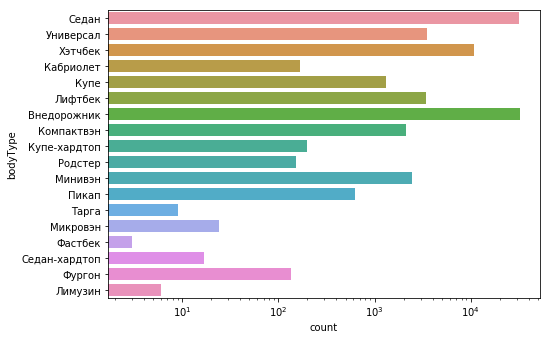

In [51]:
ttt = df.bodyType.dropna().apply(lambda x: x.split()[0])

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xscale( 'log' )
sns.countplot(y=df.bodyType.dropna().apply(lambda x: x.split()[0]))

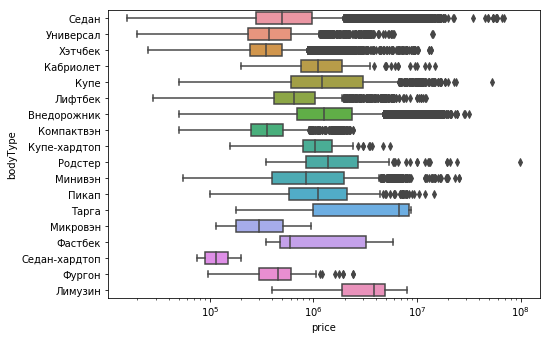

In [52]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xscale( 'log' )
sns.boxplot(x = df.price, y=ttt)

### brand

In [8]:
df_test.brand.unique()

array(['BMW'], dtype=object)

### color

In [9]:
df_test.color.unique()

array(['чёрный', 'белый', 'синий', 'коричневый', 'красный', 'серый',
       'бежевый', 'серебристый', 'золотистый', 'оранжевый', 'голубой',
       'пурпурный', 'жёлтый', 'зелёный', 'фиолетовый'], dtype=object)

In [42]:
pd.get_dummies(df.color)[:5]

,0000CC,007F00,040001,200204,22A0F8,4A2197,660099,97948F,C49648,CACECB,DEA522,EE1D19,FAFBFB,FF8649,FFC0CB,FFD600
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


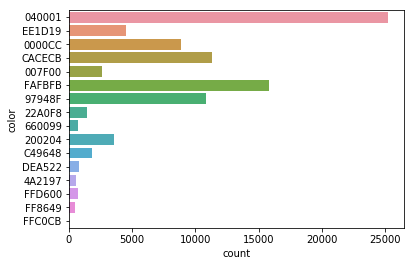

In [44]:
ttt = df.color.dropna()

fig = plt.figure()
# ax = fig.add_axes([0, 0, 1, 1])
# ax.set_xscale( 'log' )
sns.countplot(y=ttt)

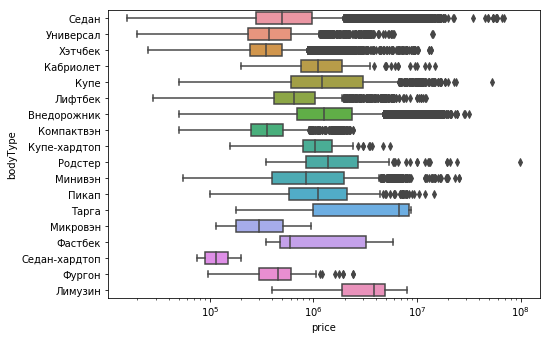

In [53]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xscale( 'log' )
sns.boxplot(x = df.price, y=ttt)

### fuelType

In [54]:
df.fuelType.unique()

array(['бензин', 'дизель', 'электро', 'гибрид', 'универсал', 'газ'],
      dtype=object)

In [55]:
pd.get_dummies(df.fuelType)[:5]

,бензин,газ,гибрид,дизель,универсал,электро
0,1,0,0,0,0,0
1,1,0,0,0,0,0
2,1,0,0,0,0,0
3,1,0,0,0,0,0
4,1,0,0,0,0,0


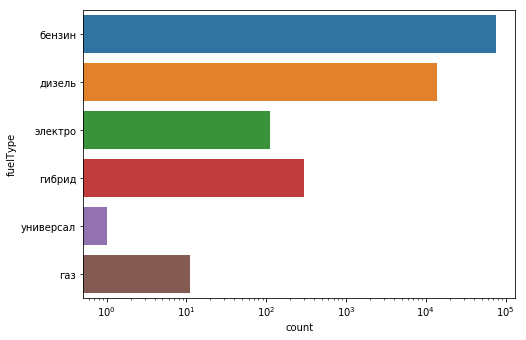

In [57]:
ttt = df.fuelType.dropna()

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xscale( 'log' )
sns.countplot(y=ttt)

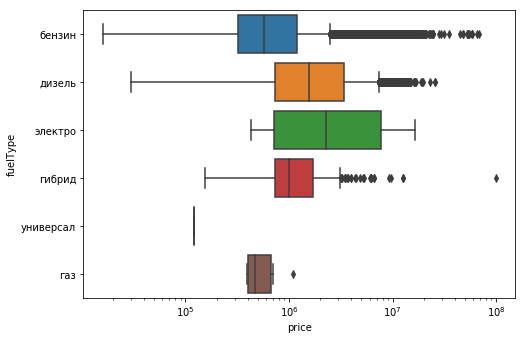

In [58]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xscale( 'log' )
sns.boxplot(x = df.price, y=ttt)

### modelDate

In [63]:
df.modelDate.dropna().unique()

array([1990., 1982., 1988., 1976., 1983., 1979., 1986., 1991., 1978.,
       1987., 1992., 1938., 2010., 2014., 2000., 2016., 2004., 2012.,
       2008., 1996., 2003., 2015., 2011., 2007., 1999., 1994., 2009.,
       2018., 2001., 1997., 2006., 2019., 2013., 2017., 2002., 2005.,
       1980., 1984., 1998., 1966., 1975., 1937., 1936., 1949., 2020.,
       1995., 1981., 1972., 1977., 1989., 1968., 1985., 1958., 1971.,
       1956., 1955., 1970., 1963., 1973., 1964., 1957., 1993., 1960.,
       1927., 1908., 1932., 1965., 1935., 1967., 1948., 1969., 1934.,
       1974., 1950., 1961., 1904., 1959., 1951.])

In [62]:
df.modelDate.dropna().astype(int)[:5]

0    1990
1    1982
2    1988
3    1988
4    1990
Name: modelDate, dtype: int32

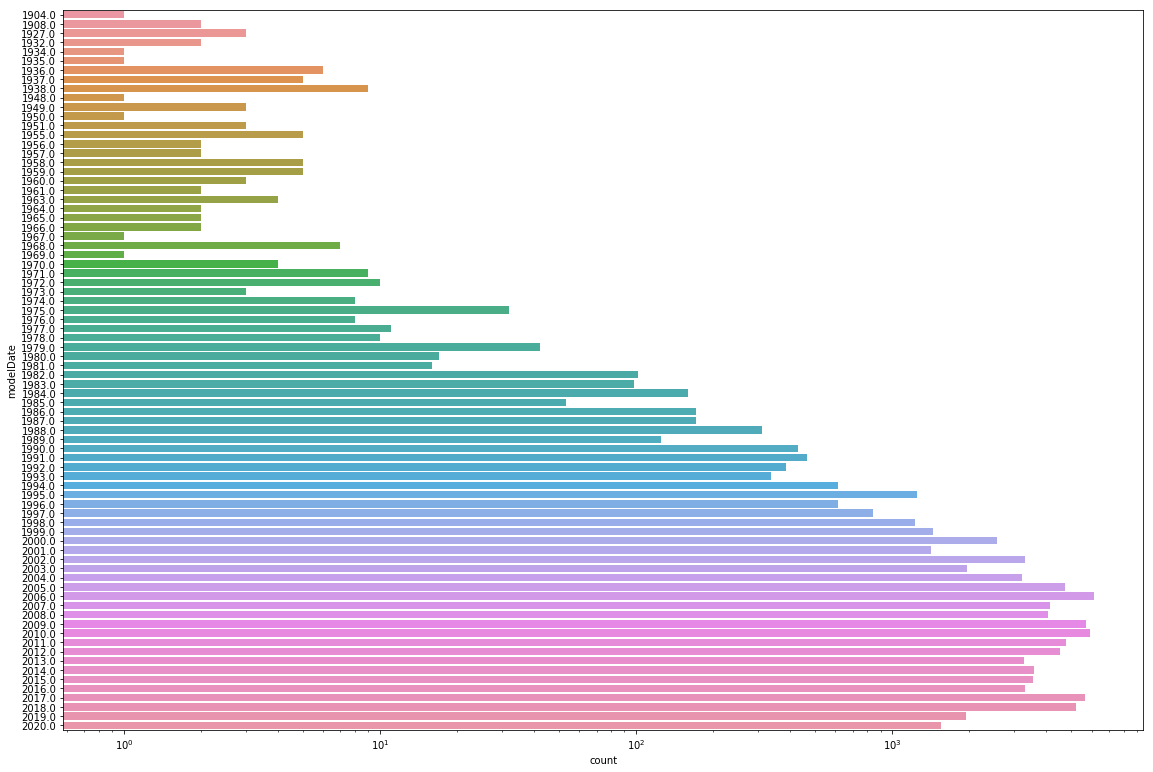

In [65]:
ttt = df.modelDate.dropna()

fig = plt.figure(figsize=(15,10))
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xscale( 'log' )
sns.countplot(y=ttt)

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xscale( 'log' )
sns.boxplot(x = df.price, y=ttt)

C:\Users\Samsung\Anaconda3\lib\site-packages\matplotlib\ticker.py:2198: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
C:\Users\Samsung\Anaconda3\lib\site-packages\matplotlib\ticker.py:2198: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
C:\Users\Samsung\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3129: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


KeyboardInterrupt: 

### name

In [ ]:
df.name.loc[0]

In [15]:
df_test.name.apply(lambda x: x[:x.find(' ')])[:5]

0    520d
1    318d
2    550i
3     30d
4    M50d
Name: name, dtype: object

In [16]:
df_test.name.apply(lambda x: x[:x.find(' ')]).unique()

array(['520d', '318d', '550i', '30d', 'M50d', '28i', '20d', '520i',
       '328i', '116i', '730d', '320i', '335i', '25i', '316i', '3.0d',
       '540i', '730Ld', '35d', '20i', '530d', '528i', '35i', 'xDrive20d',
       '48i', '135i', '2.2', '335xi', '745i', '320d', '530xi', '530i',
       '3.0i', '325i', '30i', '118i', '40i', 'M760Li', '3.0si', '4.4',
       '40d', '4.8i', '535d', '420i', '525i', '750i', '120i', '330i',
       '120d', '318i', '725Ld', '760Li', '840d', '420d', 'M850i', '523i',
       '18d', '650i', '18i', '525d', '750Li', '4.4i', '630d', '645i',
       '3.0', '25d', '535i', '640i', '330xd', 'xDrive20i', '525xi', '50i',
       '740Li', 'M550d', '630i', '4.0', '520Li', '735i', '730Li', '740d',
       '325xi', '518', 'M235i', '220i', '740i', 'Competition', 'M50i',
       '428i', '1.5', '750Ld', 'M40d', '730i', '1.5hyb', '528Li', '640d',
       '3.0sd', 'Electro', '530Li', '740Ld', 'CS', '525xd', 'M40i',
       '330xi', 'M340i', 'M550i', '750d', '35is', '760i', '125i', '130

In [17]:
df_test.name.sort_values().unique()[:10]

array(['1.5 AT (136 л.с.)', '1.5hyb AT (231 л.с.) 4WD',
       '116i 1.6 AT (115 л.с.)', '116i 1.6 AT (136 л.с.)',
       '116i 1.6 MT (115 л.с.)', '116i 1.6 MT (122 л.с.)',
       '116i 1.6 MT (136 л.с.)', '118d 2.0d MT (122 л.с.)',
       '118i 1.5 AT (136 л.с.)', '118i 1.6 AT (136 л.с.)'], dtype=object)

In [18]:
# pwr = lambda x: x[x.find('(')+1:x.find(')')]
# ltr = lambda x: x[:x.find(' ')]
# df_test.name.apply(ltr)
df_test.loc[5][['name','fuelType','engineDisplacement','vehicleTransmission','enginePower','Привод']]

name                   30d 3.0d AT (249 л.с.) 4WD
fuelType                                   дизель
engineDisplacement                        3.0 LTR
vehicleTransmission                автоматическая
enginePower                               249 N12
Привод                                     полный
Name: 5, dtype: object

### numberOfDoors

In [19]:
print(df_test.numberOfDoors.unique())
df_test.numberOfDoors.astype(int)[:5]

[4. 5. 3. 2.]


0    4
1    4
2    4
3    5
4    5
Name: numberOfDoors, dtype: int32

### productionDate

In [20]:
df_test.productionDate.unique()

array([2017., 2019., 2012., 2015., 2013., 2008., 2011., 2016., 2007.,
       2014., 2000., 2009., 2018., 2005., 2003., 2006., 2010., 2002.,
       2004., 2001., 1997., 1998., 1999., 1995., 1996., 1993., 1987.,
       1984., 1989., 1991., 1988., 1994., 1992., 1981., 1990., 1986.,
       1982.])

In [21]:
df_test.productionDate.astype(int).unique()

array([2017, 2019, 2012, 2015, 2013, 2008, 2011, 2016, 2007, 2014, 2000,
       2009, 2018, 2005, 2003, 2006, 2010, 2002, 2004, 2001, 1997, 1998,
       1999, 1995, 1996, 1993, 1987, 1984, 1989, 1991, 1988, 1994, 1992,
       1981, 1990, 1986, 1982], dtype=int64)

### vehicleConfiguration

In [39]:
# df_test.vehicleConfiguration.sort_values().unique()
df_test.vehicleConfiguration.unique()[:10]

array(['SEDAN AUTOMATIC 2.0', 'SEDAN AUTOMATIC 4.4',
       'ALLROAD_5_DOORS AUTOMATIC 3.0', 'ALLROAD_5_DOORS AUTOMATIC 2.0',
       'HATCHBACK_3_DOORS AUTOMATIC 1.6', 'SEDAN AUTOMATIC 3.0',
       'ALLROAD_5_DOORS AUTOMATIC 2.5', 'SEDAN AUTOMATIC 1.6',
       'HATCHBACK_5_DOORS MECHANICAL 1.6',
       'ALLROAD_5_DOORS AUTOMATIC 4.8'], dtype=object)

In [25]:
df_test.vehicleConfiguration[:5]

0              SEDAN AUTOMATIC 2.0
1              SEDAN AUTOMATIC 2.0
2              SEDAN AUTOMATIC 4.4
3    ALLROAD_5_DOORS AUTOMATIC 3.0
4    ALLROAD_5_DOORS AUTOMATIC 3.0
Name: vehicleConfiguration, dtype: object

In [32]:
df_test.vehicleConfiguration.str.split().head()

0              [SEDAN, AUTOMATIC, 2.0]
1              [SEDAN, AUTOMATIC, 2.0]
2              [SEDAN, AUTOMATIC, 4.4]
3    [ALLROAD_5_DOORS, AUTOMATIC, 3.0]
4    [ALLROAD_5_DOORS, AUTOMATIC, 3.0]
Name: vehicleConfiguration, dtype: object

In [29]:
df_test.vehicleConfiguration.str.split().apply(lambda x:x[0]).unique()

array(['SEDAN', 'ALLROAD_5_DOORS', 'HATCHBACK_3_DOORS',
       'HATCHBACK_5_DOORS', 'COUPE', 'ROADSTER', 'LIFTBACK',
       'WAGON_5_DOORS', 'CABRIO', 'SEDAN_2_DOORS', 'COMPACTVAN'],
      dtype=object)

In [30]:
df_test.vehicleConfiguration.str.split().apply(lambda x:x[1]).unique()

array(['AUTOMATIC', 'MECHANICAL', 'ROBOT'], dtype=object)

In [40]:
df_test.vehicleConfiguration.str.split().apply(lambda x:x[2] if len(x)==3 else np.NAN).unique()

array(['2.0', '4.4', '3.0', '1.6', '2.5', '4.8', '2.2', '6.6', '1.5',
       '6.0', '1.8', '3.5', '2.8', '4.0', '3.6', '5.4', '2.9', nan, '1.9',
       '5.0', '4.6', '3.4'], dtype=object)

### vehicleTransmission

In [23]:
df_test.vehicleTransmission.unique()

array(['автоматическая', 'механическая', 'роботизированная'], dtype=object)

### engineDisplacement

In [24]:
df_test.engineDisplacement.sort_values().unique(), #df.engineDisplacement.sort_values().unique()

(array(['1.5 LTR', '1.6 LTR', '1.8 LTR', '1.9 LTR', '2.0 LTR', '2.2 LTR',
        '2.5 LTR', '2.8 LTR', '2.9 LTR', '3.0 LTR', '3.4 LTR', '3.5 LTR',
        '3.6 LTR', '4.0 LTR', '4.4 LTR', '4.6 LTR', '4.8 LTR', '5.0 LTR',
        '5.4 LTR', '6.0 LTR', '6.6 LTR', 'undefined LTR'], dtype=object),)

In [45]:
df_test.engineDisplacement.apply(lambda x: x.split()[0])[:10]

0    2.0
1    2.0
2    4.4
3    3.0
4    3.0
5    3.0
6    2.0
7    2.0
8    3.0
9    2.0
Name: engineDisplacement, dtype: object

In [52]:
mask = (df_test.engineDisplacement.apply(lambda x: x.split()[0])!=
 df_test.vehicleConfiguration.str.split().apply(lambda x:x[2] if len(x)==3 else np.NAN))
df_test[mask][['engineDisplacement','vehicleConfiguration']]

,engineDisplacement,vehicleConfiguration
823,undefined LTR,HATCHBACK_5_DOORS AUTOMATIC


### enginePower

In [25]:
df_test.enginePower.sort_values().unique()
df_test.enginePower.str[:-4].astype(int).sort_values().unique()

array([ 90, 100, 102, 105, 113, 115, 118, 122, 125, 129, 136, 140, 143,
       150, 156, 163, 170, 177, 184, 188, 190, 192, 193, 197, 204, 211,
       218, 230, 231, 235, 243, 245, 249, 252, 258, 264, 265, 269, 272,
       286, 300, 306, 313, 320, 326, 329, 333, 340, 347, 355, 360, 367,
       370, 374, 381, 400, 407, 410, 420, 431, 445, 449, 450, 460, 462,
       507, 530, 544, 555, 560, 575, 600, 609, 610, 625], dtype=int64)

In [26]:
# df.enginePower.sort_values().unique()

### description

In [10]:
df.description.str.len()[:5]

0     228.0
1     132.0
2    1147.0
3       NaN
4     204.0
Name: description, dtype: float64

### mileage

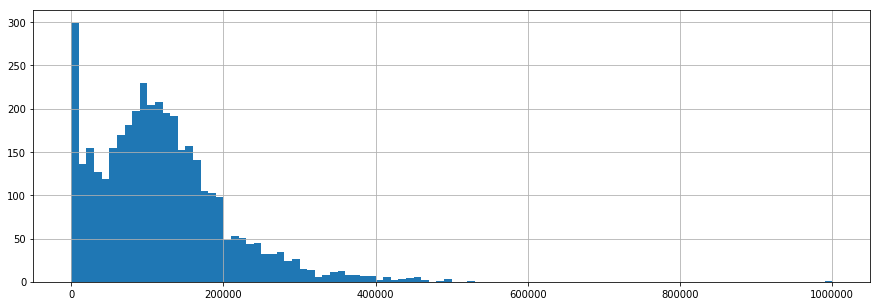

In [60]:
df_test.mileage.nunique()
df_test.mileage.hist(figsize=(15,5),bins=100)

### Комплектация

In [61]:
df_test.Комплектация.nunique()

3295

### Привод

In [63]:
df_test.Привод.unique() #, df.Привод.unique()

array(['задний', 'полный', 'передний'], dtype=object)

### Руль

In [64]:
df_test.Руль.unique() #, df_test.Руль.unique()

array(['Левый'], dtype=object)

### Состояние

In [65]:
df_test.Состояние.unique() #, df.Состояние.unique()

array(['Не требует ремонта'], dtype=object)

### Владельцы

In [66]:
df_test.Владельцы.unique() #, df.Владельцы.unique()

array(['1\xa0владелец', '2\xa0владельца', '3 или более'], dtype=object)

### ПТС

In [67]:
df_test.ПТС.unique() #, df.ПТС.unique()

array(['Оригинал', 'Дубликат'], dtype=object)

### Таможня

In [68]:
df_test.Таможня.unique()#,df_test.Таможня.unique()

array(['Растаможен'], dtype=object)

### Владение

In [70]:
df_test.Владение.sort_values().unique()[:10]

array(['1 год', '1 год и 1 месяц', '1 год и 10 месяцев',
       '1 год и 11 месяцев', '1 год и 2 месяца', '1 год и 3 месяца',
       '1 год и 4 месяца', '1 год и 5 месяцев', '1 год и 6 месяцев',
       '1 год и 7 месяцев'], dtype=object)

In [71]:
# df.Владение.sort_values().unique()[:10]

In [72]:
import re

pattern_yaer = re.compile('\d+(?= (?:год|лет))')
pattern_month = re.compile('\d+(?= мес)')

year = lambda x: int(pattern_yaer.search(x).group(0)) if pattern_yaer.search(x) else 0
month = lambda x: int(pattern_month.search(x).group(0)) if pattern_month.search(x) else 0

df_test.Владение.apply(lambda x: year(x)*12 + month(x) if x==x else x)[:10]

0     NaN
1     NaN
2    86.0
3     NaN
4     NaN
5     NaN
6    35.0
7     NaN
8    84.0
9     NaN
Name: Владение, dtype: float64

### price

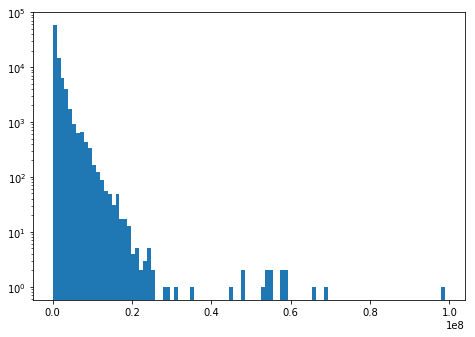

In [49]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_yscale('log')
ax.hist(df.price.dropna(),bins=100);

### start_date

In [69]:
ttt = pd.to_datetime(df.start_date,format='%Y-%m-%d')

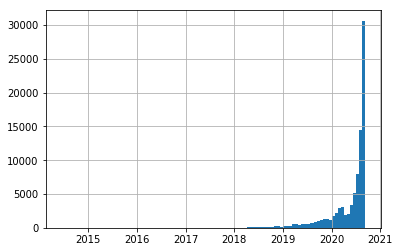

In [72]:
ttt.hist(bins=100)

### id

In [34]:
print(df_test.id.unique())
try: 
    print(df.id.unique())
except:  
    pass

[   0    1    2 ... 3834 3835 3836]


## ===============================================================

## df_test.Комплектация


In [35]:
df_test.Комплектация[0][2:-2]

'[{"name":"Безопасность","values":["Антипробуксовочная система (ASR)","Система стабилизации (ESP)","Подушка безопасности водителя","Крепление детского кресла (задний ряд) ISOFIX","Подушки безопасности оконные (шторки)","Подушка безопасности пассажира","Подушки безопасности боковые задние","Подушки безопасности боковые","Датчик давления в шинах","Антиблокировочная система (ABS)","Блокировка замков задних дверей","Подушка безопасности для защиты коленей водителя"]},{"name":"Комфорт","values":["Система «старт-стоп»","Электростеклоподъёмники передние","Мультифункциональное рулевое колесо","Прикуриватель и пепельница","Бортовой компьютер","Усилитель руля","Электропривод зеркал","Электростеклоподъёмники задние","Парктроник передний","Регулировка руля по вылету","Климат-контроль 2-зонный","Электроскладывание зеркал","Парктроник задний"]},{"name":"Мультимедиа","values":["AUX","USB","Аудиосистема","Bluetooth"]},{"name":"Обзор","values":["Датчик света","Автоматический корректор фар","Омыватель ф

In [36]:
new_configuration = df_test.Комплектация.apply(lambda x: json.loads(x[2:-2]) if x != '[]' else [])
new_configuration.head()

0    [{'name': 'Безопасность', 'values': ['Антипроб...
1    [{'name': 'Комфорт', 'values': ['Круиз-контрол...
2    [{'name': 'Комфорт', 'values': ['Круиз-контрол...
3    [{'name': 'Комфорт', 'values': ['Круиз-контрол...
4    [{'name': 'Комфорт', 'values': ['Круиз-контрол...
Name: Комплектация, dtype: object

In [37]:
# lambda configuration: [category['name'] for category in configuration]
all_categories = set(new_configuration.apply(lambda configuration: [category['name'] for category in configuration]).sum())
all_categories

{'Безопасность',
 'Защита от угона',
 'Комфорт',
 'Мультимедиа',
 'Обзор',
 'Прочее',
 'Салон',
 'Элементы экстерьера'}

In [38]:
new_configuration[0]

[{'name': 'Безопасность',
  'values': ['Антипробуксовочная система (ASR)',
   'Система стабилизации (ESP)',
   'Подушка безопасности водителя',
   'Крепление детского кресла (задний ряд) ISOFIX',
   'Подушки безопасности оконные (шторки)',
   'Подушка безопасности пассажира',
   'Подушки безопасности боковые задние',
   'Подушки безопасности боковые',
   'Датчик давления в шинах',
   'Антиблокировочная система (ABS)',
   'Блокировка замков задних дверей',
   'Подушка безопасности для защиты коленей водителя']},
 {'name': 'Комфорт',
  'values': ['Система «старт-стоп»',
   'Электростеклоподъёмники передние',
   'Мультифункциональное рулевое колесо',
   'Прикуриватель и пепельница',
   'Бортовой компьютер',
   'Усилитель руля',
   'Электропривод зеркал',
   'Электростеклоподъёмники задние',
   'Парктроник передний',
   'Регулировка руля по вылету',
   'Климат-контроль 2-зонный',
   'Электроскладывание зеркал',
   'Парктроник задний']},
 {'name': 'Мультимедиа',
  'values': ['AUX', 'USB', '

In [39]:
def category_separation(category,row):
    for cat in row:
        if(cat['name'] == category) : 
            return cat['values']
    return []

In [40]:
new_configuration.apply(lambda x: category_separation('Салон',x))

0       [Регулировка передних сидений по высоте, Перед...
1       [Спортивные передние сиденья, Передний централ...
2       [Спортивные передние сиденья, Люк, Подогрев за...
3       [Передний центральный подлокотник, Складывающе...
4       [Передний центральный подлокотник, Люк, Подогр...
                              ...                        
3832    [Тонированные стекла, Отделка кожей рычага КПП...
3833    [Тонированные стекла, Передний центральный под...
3834    [Кожа (Материал салона), Обогрев рулевого коле...
3835    [Кожа (Материал салона), Обогрев рулевого коле...
3836    [Складывающееся заднее сиденье, Электрорегулир...
Name: Комплектация, Length: 3837, dtype: object

In [41]:
category_separation('Салон',new_configuration[0])

['Регулировка передних сидений по высоте',
 'Передний центральный подлокотник',
 'Складывающееся заднее сиденье',
 'Электрорегулировка передних сидений',
 'Тёмный салон',
 'Кожа (Материал салона)',
 'Обогрев рулевого колеса',
 'Подогрев передних сидений',
 'Отделка кожей рулевого колеса']

## ===============================================================
## ===============================================================
## df_test.Комплектация

In [42]:
df_test.Комплектация[0][2:-2]

'[{"name":"Безопасность","values":["Антипробуксовочная система (ASR)","Система стабилизации (ESP)","Подушка безопасности водителя","Крепление детского кресла (задний ряд) ISOFIX","Подушки безопасности оконные (шторки)","Подушка безопасности пассажира","Подушки безопасности боковые задние","Подушки безопасности боковые","Датчик давления в шинах","Антиблокировочная система (ABS)","Блокировка замков задних дверей","Подушка безопасности для защиты коленей водителя"]},{"name":"Комфорт","values":["Система «старт-стоп»","Электростеклоподъёмники передние","Мультифункциональное рулевое колесо","Прикуриватель и пепельница","Бортовой компьютер","Усилитель руля","Электропривод зеркал","Электростеклоподъёмники задние","Парктроник передний","Регулировка руля по вылету","Климат-контроль 2-зонный","Электроскладывание зеркал","Парктроник задний"]},{"name":"Мультимедиа","values":["AUX","USB","Аудиосистема","Bluetooth"]},{"name":"Обзор","values":["Датчик света","Автоматический корректор фар","Омыватель ф

In [43]:
# ttt = '[' + df.Комплектация.loc[89350] + ']'
ttt = df.Комплектация.loc[89350]
ttt.replace("'",'""')

NameError: name 'df' is not defined

In [ ]:
json.loads(ttt)

# ПОДВАЛ
df = pd.read_csv('./Project_5_data/all_auto_ru_09_09_2020.csv')

In [44]:
tt = df_test.Комплектация[0]
tt

'[\'[{"name":"Безопасность","values":["Антипробуксовочная система (ASR)","Система стабилизации (ESP)","Подушка безопасности водителя","Крепление детского кресла (задний ряд) ISOFIX","Подушки безопасности оконные (шторки)","Подушка безопасности пассажира","Подушки безопасности боковые задние","Подушки безопасности боковые","Датчик давления в шинах","Антиблокировочная система (ABS)","Блокировка замков задних дверей","Подушка безопасности для защиты коленей водителя"]},{"name":"Комфорт","values":["Система «старт-стоп»","Электростеклоподъёмники передние","Мультифункциональное рулевое колесо","Прикуриватель и пепельница","Бортовой компьютер","Усилитель руля","Электропривод зеркал","Электростеклоподъёмники задние","Парктроник передний","Регулировка руля по вылету","Климат-контроль 2-зонный","Электроскладывание зеркал","Парктроник задний"]},{"name":"Мультимедиа","values":["AUX","USB","Аудиосистема","Bluetooth"]},{"name":"Обзор","values":["Датчик света","Автоматический корректор фар","Омывател

In [45]:
tt

'[\'[{"name":"Безопасность","values":["Антипробуксовочная система (ASR)","Система стабилизации (ESP)","Подушка безопасности водителя","Крепление детского кресла (задний ряд) ISOFIX","Подушки безопасности оконные (шторки)","Подушка безопасности пассажира","Подушки безопасности боковые задние","Подушки безопасности боковые","Датчик давления в шинах","Антиблокировочная система (ABS)","Блокировка замков задних дверей","Подушка безопасности для защиты коленей водителя"]},{"name":"Комфорт","values":["Система «старт-стоп»","Электростеклоподъёмники передние","Мультифункциональное рулевое колесо","Прикуриватель и пепельница","Бортовой компьютер","Усилитель руля","Электропривод зеркал","Электростеклоподъёмники задние","Парктроник передний","Регулировка руля по вылету","Климат-контроль 2-зонный","Электроскладывание зеркал","Парктроник задний"]},{"name":"Мультимедиа","values":["AUX","USB","Аудиосистема","Bluetooth"]},{"name":"Обзор","values":["Датчик света","Автоматический корректор фар","Омывател

In [46]:
pd.__version__

'0.25.1'

In [47]:
np.__version__

'1.16.5'

https://www.youtube.com/watch?v=cQPcEZoxvi0  
http://jsonviewer.stack.hu/  
https://www.youtube.com/watch?v=ykjBVT57r68  
https://pythonru.com/biblioteki/kratkoe-rukovodstvo-po-biblioteke-python-requests  


In [48]:
df = pd.read_csv('./Project_5_data/all_auto_ru_09_09_2020.csv')

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89378 entries, 0 to 89377
Data columns (total 26 columns):
bodyType                89377 non-null object
brand                   89378 non-null object
color                   89378 non-null object
fuelType                89378 non-null object
modelDate               89377 non-null float64
name                    89377 non-null object
numberOfDoors           89377 non-null float64
productionDate          89378 non-null int64
vehicleConfiguration    89377 non-null object
vehicleTransmission     89377 non-null object
engineDisplacement      89377 non-null object
enginePower             89377 non-null float64
description             86124 non-null object
mileage                 89378 non-null int64
Комплектация            89378 non-null object
Привод                  89377 non-null object
Руль                    89378 non-null object
Состояние               0 non-null float64
Владельцы               75790 non-null float64
ПТС               

In [50]:
df[df.brand == 'BMW'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7393 entries, 4084 to 11476
Data columns (total 26 columns):
bodyType                7393 non-null object
brand                   7393 non-null object
color                   7393 non-null object
fuelType                7393 non-null object
modelDate               7393 non-null float64
name                    7393 non-null object
numberOfDoors           7393 non-null float64
productionDate          7393 non-null int64
vehicleConfiguration    7393 non-null object
vehicleTransmission     7393 non-null object
engineDisplacement      7393 non-null object
enginePower             7393 non-null float64
description             7216 non-null object
mileage                 7393 non-null int64
Комплектация            7393 non-null object
Привод                  7393 non-null object
Руль                    7393 non-null object
Состояние               0 non-null float64
Владельцы               5109 non-null float64
ПТС                     7293 non-n

In [51]:
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
image_urls = Parallel(n_jobs = 5)(delayed(link_to_images)(link) for link in tqdm(list(links)))

NameError: name 'links' is not defined

![](https://files.slack.com/files-pri/TV73V5ZRT-F01DX5HQ3C3/image.png)
Синтаксис распараллеливания в целом такой
```python
result = [delayed(func)(x) for x in arr]
```

In [ ]:
import re

pattern_yaer = re.compile('\d+(?= (?:год|лет))')
pattern_month = re.compile('\d+(?= мес)')

year = lambda x: int(pattern_yaer.search(x).group(0)) if pattern_yaer.search(x) else 0
month = lambda x: int(pattern_month.search(x).group(0)) if pattern_month.search(x) else 0



months_count = lambda x: year(x)*12 + month(x) if x==x else x

months_count(df_test.Владение[0])

In [ ]:
# df = pd.read_csv('./Project_5_data/all_auto_ru_09_09_2020.csv')

In [7]:
df.describe(include='all',percentiles=[0.5]).T

,count,unique,top,freq,mean,std,min,50%,max
bodyType,89377,168,Внедорожник 5 дв.,31885,NaN,NaN,NaN,NaN,NaN
brand,89378,36,MERCEDES,8012,NaN,NaN,NaN,NaN,NaN
color,89378,16,040001,25212,NaN,NaN,NaN,NaN,NaN
fuelType,89378,6,бензин,75053,NaN,NaN,NaN,NaN,NaN
modelDate,89377,NaN,NaN,NaN,2008.54,7.41544,1904,2009,2020
name,89377,4484,2.0 AT (150 л.с.),1610,NaN,NaN,NaN,NaN,NaN
numberOfDoors,89377,NaN,NaN,NaN,4.51047,0.653203,0,5,5
productionDate,89378,NaN,NaN,NaN,2010.83,7.02478,1904,2011,2020
vehicleConfiguration,89377,1860,SEDAN MECHANICAL 1.6,4166,NaN,NaN,NaN,NaN,NaN
vehicleTransmission,89377,4,AUTOMATIC,49218,NaN,NaN,NaN,NaN,NaN


In [22]:
# [df[col].value_counts().iloc[0] for col in  df.columns]
[df[col].value_counts().iloc[0] 
 if len(df[col].value_counts())!=0 else np.NAN 
 for col in  df.columns]

[31885,
 8012,
 25212,
 75053,
 6138,
 1610,
 51625,
 12524,
 4166,
 49218,
 17032,
 7058,
 246,
 13588,
 59130,
 47315,
 87589,
 nan,
 36248,
 78597,
 89378,
 497,
 1212,
 93,
 nan,
 2467]

In [16]:
5%2

1

In [2]:
ttt = '''AC
3
AMC
2
Acura
65
Alfa Romeo
54
Alpina
6
Ariel
1
Aro
1
Asia
1
Aston Martin
19
Audi
3094
Austin Healey
1
BMW
5819
BYD
20
Bentley
93
Borgward
1
Brilliance
17
Bugatti
1
Buick
12
CHERYEXEED
13
Cadillac
484
ChangFeng
1
Changan
154
Chery
446
Chevrolet
2643
Chrysler
253
Citroen
882
DKW
2
DS
1
DW Hower
5
Dacia
9
Dadi
1
Daewoo
671
Daihatsu
37
Daimler
3
Datsun
182
Delage
1
Derways
2
Dodge
305
DongFeng
13
Doninvest
1
Eagle
2
Excalibur
1
FAW
54
Ferrari
22
Fiat
171
Ford
3334
GAC
3
GMC
23
Geely
276
Genesis
29
Great Wall
323
Hafei
4
Haima
11
Haval
186
Hawtai
3
Heinkel
1
Honda
827
HuangHai
1
Hummer
50
Hyundai
4153
Infiniti
672
Iran Khodro
25
Isuzu
25
JAC
7
Jaguar
283
Jeep
361
Kia
4131
LADA (ВАЗ)
7325
Lamborghini
10
Lancia
7
Land Rover
1462
Lexus
740
Lifan
211
Lincoln
58
Luxgen
15
MG
5
MINI
387
Maserati
38
Maybach
7
Mazda
1799
McLaren
3
Mercedes-Benz
10044
Mercury
17
Metrocab
1
Mitsubishi
2852
Mitsuoka
1
Nissan
4275
Oldsmobile
5
Opel
2235
PUCH
1
Packard
2
Peugeot
1218
Plymouth
14
Pontiac
20
Porsche
636
RAM
4
Ravon
95
Renault
2534
Rolls-Royce
53
Rover
53
SEAT
65
Saab
112
Saturn
5
Scion
6
Shanghai Maple
1
Skoda
2403
Smart
74
SsangYong
473
Subaru
526
Suzuki
889
Tatra
1
Tesla
48
Toyota
3013
Triumph
1
Volkswagen
4962
Volvo
1477
Vortex
66
Willys
2
Xin Kai
1
ZX
3
Zotye
16
ГАЗ
809
Гоночный болид
3
ЗАЗ
197
ЗИЛ
3
ЗиС
1
ИЖ
104
ЛуАЗ
36
Москвич
182
СМЗ
3
ТагАЗ
50
УАЗ
873'''


In [9]:
ttt.split('\n')[0::2]

['AC',
 'AMC',
 'Acura',
 'Alfa Romeo',
 'Alpina',
 'Ariel',
 'Aro',
 'Asia',
 'Aston Martin',
 'Audi',
 'Austin Healey',
 'BMW',
 'BYD',
 'Bentley',
 'Borgward',
 'Brilliance',
 'Bugatti',
 'Buick',
 'CHERYEXEED',
 'Cadillac',
 'ChangFeng',
 'Changan',
 'Chery',
 'Chevrolet',
 'Chrysler',
 'Citroen',
 'DKW',
 'DS',
 'DW Hower',
 'Dacia',
 'Dadi',
 'Daewoo',
 'Daihatsu',
 'Daimler',
 'Datsun',
 'Delage',
 'Derways',
 'Dodge',
 'DongFeng',
 'Doninvest',
 'Eagle',
 'Excalibur',
 'FAW',
 'Ferrari',
 'Fiat',
 'Ford',
 'GAC',
 'GMC',
 'Geely',
 'Genesis',
 'Great Wall',
 'Hafei',
 'Haima',
 'Haval',
 'Hawtai',
 'Heinkel',
 'Honda',
 'HuangHai',
 'Hummer',
 'Hyundai',
 'Infiniti',
 'Iran Khodro',
 'Isuzu',
 'JAC',
 'Jaguar',
 'Jeep',
 'Kia',
 'LADA (ВАЗ)',
 'Lamborghini',
 'Lancia',
 'Land Rover',
 'Lexus',
 'Lifan',
 'Lincoln',
 'Luxgen',
 'MG',
 'MINI',
 'Maserati',
 'Maybach',
 'Mazda',
 'McLaren',
 'Mercedes-Benz',
 'Mercury',
 'Metrocab',
 'Mitsubishi',
 'Mitsuoka',
 'Nissan',
 'Oldsmob